In [31]:
# pip install catboost

# Importing necessary libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix

from imblearn.combine import SMOTEENN
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Load the data

In [33]:
data = pd.read_excel("oasis_longitudinal_demographics.xlsx")

# Display first few rows of the data

In [34]:
print(data.head())

  Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  EDUC  \
0  OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87    14   
1  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88    14   
2  OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75    12   
3  OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76    12   
4  OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80    12   

   SES  MMSE  CDR         eTIV      nWBV       ASF  
0  2.0  27.0  0.0  1986.550000  0.696106  0.883440  
1  2.0  30.0  0.0  2004.479526  0.681062  0.875539  
2  NaN  23.0  0.5  1678.290000  0.736336  1.045710  
3  NaN  28.0  0.5  1737.620000  0.713402  1.010000  
4  NaN  22.0  0.5  1697.911134  0.701236  1.033623  


# Display last few rows of the data

In [35]:
print(data.tail())

    Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  \
368  OAS2_0185  OAS2_0185_MR2     Demented      2       842   M    R   82   
369  OAS2_0185  OAS2_0185_MR3     Demented      3      2297   M    R   86   
370  OAS2_0186  OAS2_0186_MR1  Nondemented      1         0   F    R   61   
371  OAS2_0186  OAS2_0186_MR2  Nondemented      2       763   F    R   63   
372  OAS2_0186  OAS2_0186_MR3  Nondemented      3      1608   F    R   65   

     EDUC  SES  MMSE  CDR         eTIV      nWBV       ASF  
368    16  1.0  28.0  0.5  1692.880000  0.693926  1.036690  
369    16  1.0  26.0  0.5  1688.009649  0.675457  1.039686  
370    13  2.0  30.0  0.0  1319.020000  0.801006  1.330540  
371    13  2.0  30.0  0.0  1326.650000  0.795981  1.322890  
372    13  2.0  30.0  0.0  1332.944463  0.801248  1.316634  



# Display descriptive statistics

In [36]:
print(data.describe())

            Visit     MR Delay         Age        EDUC         SES  \
count  373.000000   373.000000  373.000000  373.000000  354.000000   
mean     1.882038   595.104558   77.013405   14.597855    2.460452   
std      0.922843   635.485118    7.640957    2.876339    1.134005   
min      1.000000     0.000000   60.000000    6.000000    1.000000   
25%      1.000000     0.000000   71.000000   12.000000    2.000000   
50%      2.000000   552.000000   77.000000   15.000000    2.000000   
75%      2.000000   873.000000   82.000000   16.000000    3.000000   
max      5.000000  2639.000000   98.000000   23.000000    5.000000   

             MMSE         CDR         eTIV        nWBV         ASF  
count  371.000000  373.000000   373.000000  373.000000  373.000000  
mean    27.342318    0.290885  1488.121584    0.729556    1.195460  
std      3.683244    0.374557   176.135956    0.037141    0.138105  
min      4.000000    0.000000  1105.652499    0.644399    0.875539  
25%     27.000000    0.0

# Select only numeric columns and calculate statistics

In [37]:
numeric_data = data.select_dtypes(include='number')
min_values = numeric_data.min()
max_values = numeric_data.max()
mean_values = numeric_data.mean()
median_values = numeric_data.median()
stats_table = pd.DataFrame({
    'Min': min_values,
    'Max': max_values,
    'Mean': mean_values,
    'Median': median_values
})
print(stats_table)

                  Min          Max         Mean       Median
Visit        1.000000     5.000000     1.882038     2.000000
MR Delay     0.000000  2639.000000   595.104558   552.000000
Age         60.000000    98.000000    77.013405    77.000000
EDUC         6.000000    23.000000    14.597855    15.000000
SES          1.000000     5.000000     2.460452     2.000000
MMSE         4.000000    30.000000    27.342318    29.000000
CDR          0.000000     2.000000     0.290885     0.000000
eTIV      1105.652499  2004.479526  1488.121584  1470.041312
nWBV         0.644399     0.836842     0.729556     0.728789
ASF          0.875539     1.587298     1.195460     1.193844


# Separate features and target variable

In [38]:
x = data.drop(columns=['Group'])
y = data['Group']

# Encode categorical variables in x

In [39]:
labels_to_encode = ['Subject ID', 'MRI ID', 'M/F', 'Hand']
label_encoder = LabelEncoder()
for label in labels_to_encode:
    x[label] = label_encoder.fit_transform(x[label])

# Encode categorical variables in y (Group)

In [40]:
label_encoder_y = LabelEncoder()
y = label_encoder_y.fit_transform(y)
print(f"Original classes in y: {label_encoder_y.classes_}")

Original classes in y: ['Converted' 'Demented' 'Nondemented']


# Heatmap for missing data before imputation

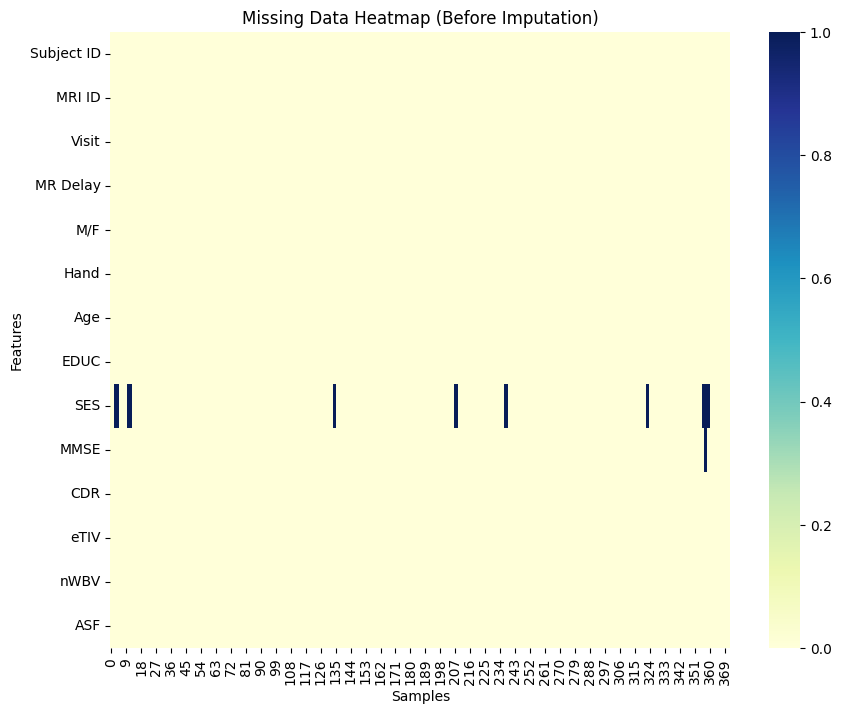

In [41]:
# Transpose the data to put features on the y-axis
data_transposed = x.transpose()
# Create a boolean DataFrame indicating missing values
missing_data = data_transposed.isnull()
# Plot missing data heatmap before imputation
plt.figure(figsize=(10, 8))
sns.heatmap(missing_data, cmap='YlGnBu', yticklabels=True)
plt.xlabel('Samples')
plt.ylabel('Features')
plt.title('Missing Data Heatmap (Before Imputation)')
plt.show()

# Impute missing values

In [42]:
mean_imputer = SimpleImputer(strategy='mean')
x[['SES']] = mean_imputer.fit_transform(x[['SES']])
mode_imputer = SimpleImputer(strategy='most_frequent')
x[['MMSE']] = mode_imputer.fit_transform(x[['MMSE']])

# Heatmap for missing data after imputation

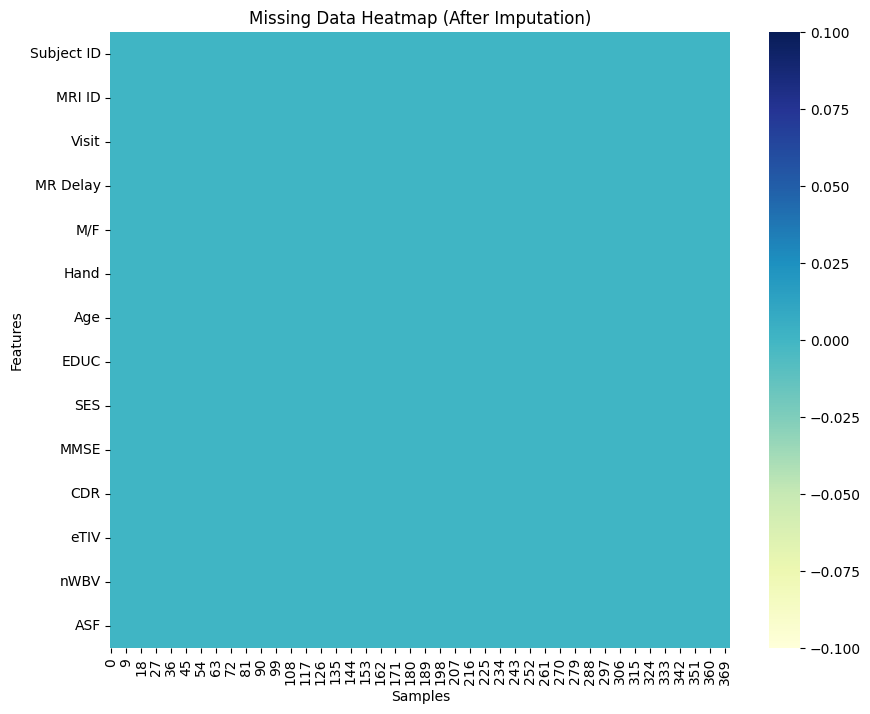

In [43]:
from matplotlib.colors import LinearSegmentedColormap

# Transpose the data to put features on the y-axis
data_transposed = x.transpose()

# Create a boolean DataFrame indicating missing values
missing_data = data_transposed.isnull()

# Plot the heatmap with the custom colormap
plt.figure(figsize=(10, 8))
sns.heatmap(missing_data, cmap='YlGnBu', yticklabels=True)
plt.xlabel('Samples')
plt.ylabel('Features')
plt.title('Missing Data Heatmap (After Imputation)')
plt.show()

# First few rows before the processing the data

In [44]:
print(x.head())

   Subject ID  MRI ID  Visit  MR Delay  M/F  Hand  Age  EDUC       SES  MMSE  \
0           0       0      1         0    1     0   87    14  2.000000  27.0   
1           0       1      2       457    1     0   88    14  2.000000  30.0   
2           1       2      1         0    1     0   75    12  2.460452  23.0   
3           1       3      2       560    1     0   76    12  2.460452  28.0   
4           1       4      3      1895    1     0   80    12  2.460452  22.0   

   CDR         eTIV      nWBV       ASF  
0  0.0  1986.550000  0.696106  0.883440  
1  0.0  2004.479526  0.681062  0.875539  
2  0.5  1678.290000  0.736336  1.045710  
3  0.5  1737.620000  0.713402  1.010000  
4  0.5  1697.911134  0.701236  1.033623  


# Standardizing the features

In [45]:
features_to_scale = ['MR Delay', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']
scaler = StandardScaler()
x[features_to_scale] = scaler.fit_transform(x[features_to_scale])

# first few rows after processing the data

In [46]:
print(x.head())

   Subject ID  MRI ID  Visit  MR Delay  M/F  Hand       Age      EDUC  \
0           0       0      1 -0.937715    1     0  1.308738 -0.208132   
1           0       1      2 -0.217613    1     0  1.439787 -0.208132   
2           1       2      1 -0.937715    1     0 -0.263856 -0.904394   
3           1       3      2 -0.055315    1     0 -0.132806 -0.904394   
4           1       4      3  2.048264    1     0  0.391392 -0.904394   

        SES      MMSE  CDR      eTIV      nWBV       ASF  
0 -0.417385 -0.097064  0.0  2.833595 -0.901820 -2.262325  
1 -0.417385  0.719588  0.0  2.935525 -1.307414 -2.319612  
2  0.000000 -1.185934  0.5  1.081119  0.182804 -1.085775  
3  0.000000  0.175153  0.5  1.418413 -0.435510 -1.344693  
4  0.000000 -1.458152  0.5  1.192666 -0.763512 -1.173413  


# Selecting k-best features and displaying scores for each feature

In [47]:
k_best_features = 6
selector = SelectKBest(score_func=f_classif, k=k_best_features)
selected_features = selector.fit_transform(x, y)
scores = selector.scores_
feature_names = x.columns

print("Score value of each attribute using F-class scoring function:")
for feature_name, score in zip(feature_names, scores):
    print(f"{feature_name}: {round(score, 4)}")

Score value of each attribute using F-class scoring function:
Subject ID: 0.059
MRI ID: 0.0549
Visit: 3.2346
MR Delay: 6.627
M/F: 13.4131
Hand: nan
Age: 3.1327
EDUC: 13.4857
SES: 13.6892
MMSE: 107.2164
CDR: 436.909
eTIV: 0.6701
nWBV: 20.5168
ASF: 0.3817


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [5] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


# Displaying k-best features

In [48]:
selected_feature_names = feature_names[selector.get_support()]
print("Selected features:")
for feature_name in selected_feature_names:
    print(feature_name)

Selected features:
M/F
EDUC
SES
MMSE
CDR
nWBV


# correlation heatmap

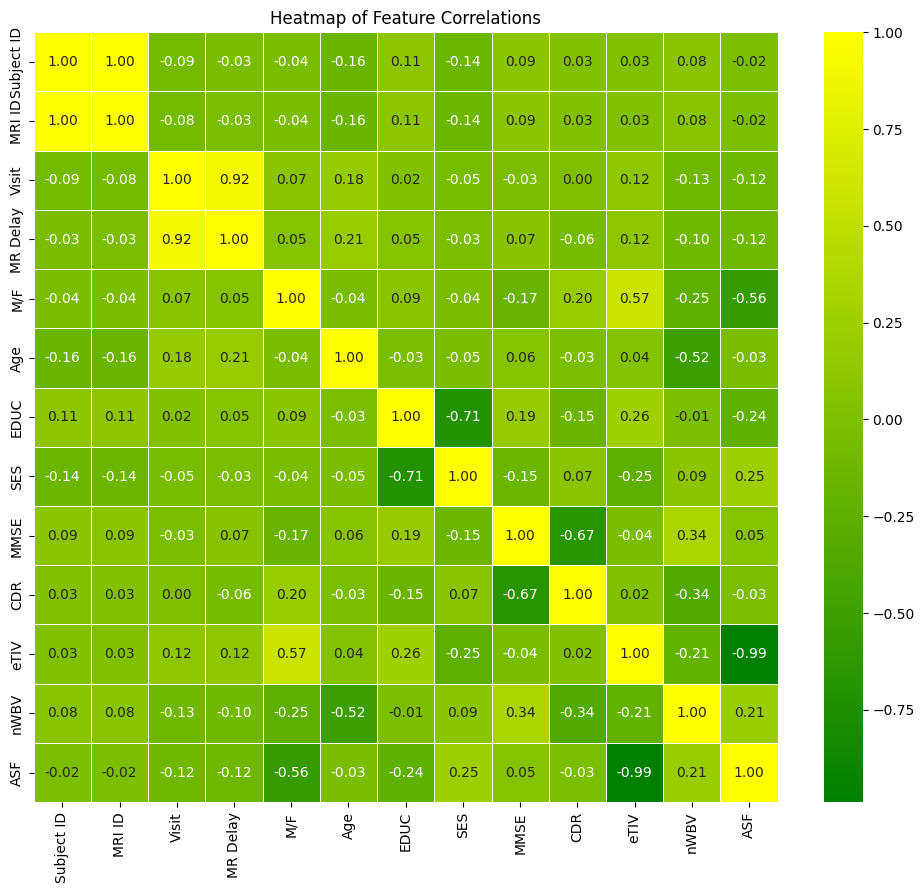

In [49]:
x = x.drop(columns=['Hand'])

# Create a correlation matrix
corr_matrix = x.corr()

# Define a custom colormap that transitions from green to yellow
colors = ['green', 'yellow']
custom_cmap = LinearSegmentedColormap.from_list('GreenYellow', colors)

# Plot the heatmap for the correlation matrix using the custom colormap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap=custom_cmap, fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Feature Correlations')
plt.show()

# splitting the data for training and testing

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Applying SMOTEENN

In [51]:
smoteenn = SMOTEENN(random_state=42)
x_train_smote, y_train_smote = smoteenn.fit_resample(x_train, y_train)

# Defining the models

In [52]:
models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42, max_depth=None, min_samples_split=2, min_samples_leaf=1),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, max_depth=None, min_samples_split=2, min_samples_leaf=1),
    "XGBoost": xgb.XGBClassifier(random_state=42, learning_rate=0.1, n_estimators=100, max_depth=3, min_child_weight=1, subsample=1.0, colsample_bytree=1.0),
    "GradientBoosting": GradientBoostingClassifier(random_state=42, learning_rate=0.1, n_estimators=100, max_depth=3, min_samples_split=2, min_samples_leaf=1),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=100, random_state=42),
}

# 15-fold cross-validation

In [53]:
cv_results = {}
# Perform 15-fold cross-validation for each model
for name, model in models.items():
    kf = KFold(n_splits=15, shuffle=True, random_state=42)
    cv_scores_acc = cross_val_score(model, x_train_smote, y_train_smote, cv=kf, scoring='accuracy', n_jobs=-1)
    cv_scores_prec = cross_val_score(model, x_train_smote, y_train_smote, cv=kf, scoring='precision_weighted', n_jobs=-1)
    cv_scores_rec = cross_val_score(model, x_train_smote, y_train_smote, cv=kf, scoring='recall_weighted', n_jobs=-1)
    cv_scores_f1 = cross_val_score(model, x_train_smote, y_train_smote, cv=kf, scoring='f1_weighted', n_jobs=-1)

    cv_results[name] = {
        "Accuracy": round(cv_scores_acc.mean(), 2),
        "Precision": round(cv_scores_prec.mean(), 2),
        "Recall": round(cv_scores_rec.mean(), 2),
        "F1 Score": round(cv_scores_f1.mean(), 2)
    }

# Applying Voting Classifier

In [54]:
from sklearn.ensemble import VotingClassifier

# Create tuples for each model to be used in the VotingClassifier
model_tuples = [(name, model) for name, model in models.items()]

# Create the VotingClassifier
voting_classifier = VotingClassifier(estimators=model_tuples, voting='hard')

# Perform 15-fold cross-validation for the voting classifier
kf = KFold(n_splits=15, shuffle=True, random_state=42)
cv_scores_acc = cross_val_score(voting_classifier, x_train_smote, y_train_smote, cv=kf, scoring='accuracy', n_jobs=-1)
cv_scores_prec = cross_val_score(voting_classifier, x_train_smote, y_train_smote, cv=kf, scoring='precision_weighted', n_jobs=-1)
cv_scores_rec = cross_val_score(voting_classifier, x_train_smote, y_train_smote, cv=kf, scoring='recall_weighted', n_jobs=-1)
cv_scores_f1 = cross_val_score(voting_classifier, x_train_smote, y_train_smote, cv=kf, scoring='f1_weighted', n_jobs=-1)

cv_results["Voting Classifier"]={
    "Accuracy": round(cv_scores_acc.mean(), 2),
    "Precision": round(cv_scores_prec.mean(), 2),
    "Recall": round(cv_scores_rec.mean(), 2),
    "F1 Score": round(cv_scores_f1.mean(), 2)
}


# Applying CatBoost Classifier

In [55]:
catboost_model = CatBoostClassifier(random_state=42)

# Perform 15-fold cross-validation for CatBoost
kf = KFold(n_splits=15, shuffle=True, random_state=42)
cv_scores_acc = cross_val_score(catboost_model, x_train_smote, y_train_smote, cv=kf, scoring='accuracy', n_jobs=-1)
cv_scores_prec = cross_val_score(catboost_model, x_train_smote, y_train_smote, cv=kf, scoring='precision_weighted', n_jobs=-1)
cv_scores_rec = cross_val_score(catboost_model, x_train_smote, y_train_smote, cv=kf, scoring='recall_weighted', n_jobs=-1)
cv_scores_f1 = cross_val_score(catboost_model, x_train_smote, y_train_smote, cv=kf, scoring='f1_weighted', n_jobs=-1)

# Compute the mean scores
cv_results["CatBoost"]={
    "Accuracy": round(cv_scores_acc.mean(), 2),
    "Precision": round(cv_scores_prec.mean(), 2),
    "Recall": round(cv_scores_rec.mean(), 2),
    "F1 Score": round(cv_scores_f1.mean(), 2)
}


# Printing the results

In [57]:
# Convert results to DataFrame
print(cv_results)
cv_results_df = pd.DataFrame(cv_results)

# Print cross-validation results as a table
print(cv_results_df)

{'DecisionTree': {'Accuracy': 0.95, 'Precision': 0.96, 'Recall': 0.95, 'F1 Score': 0.95}, 'RandomForest': {'Accuracy': 0.99, 'Precision': 0.99, 'Recall': 0.99, 'F1 Score': 0.99}, 'XGBoost': {'Accuracy': 0.98, 'Precision': 0.98, 'Recall': 0.98, 'F1 Score': 0.98}, 'GradientBoosting': {'Accuracy': 0.98, 'Precision': 0.99, 'Recall': 0.98, 'F1 Score': 0.98}, 'ExtraTrees': {'Accuracy': 0.99, 'Precision': 0.99, 'Recall': 0.99, 'F1 Score': 0.99}, 'Voting Classifier': {'Accuracy': 0.99, 'Precision': 0.99, 'Recall': 0.99, 'F1 Score': 0.99}, 'CatBoost': {'Accuracy': 0.99, 'Precision': 0.99, 'Recall': 0.99, 'F1 Score': 0.99}}
           DecisionTree  RandomForest  XGBoost  GradientBoosting  ExtraTrees  \
Accuracy           0.95          0.99     0.98              0.98        0.99   
Precision          0.96          0.99     0.98              0.99        0.99   
Recall             0.95          0.99     0.98              0.98        0.99   
F1 Score           0.95          0.99     0.98            

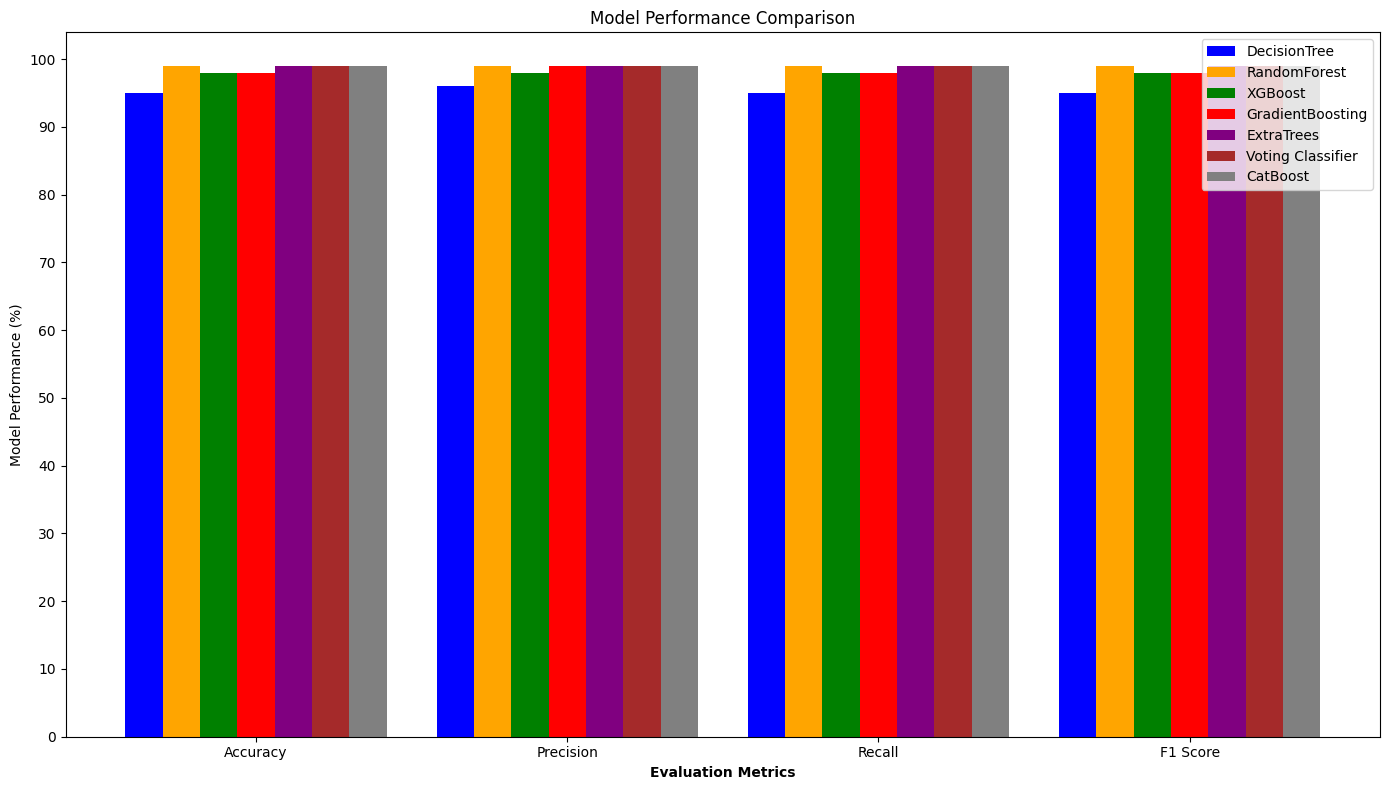

In [58]:
df = pd.DataFrame(cv_results).T

# Extract metrics and models
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
model_names = df.index
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'grey']

# Number of metrics and models
num_metrics = len(metrics)
num_models = len(model_names)

# Bar width and positions
bar_width = 0.12
index = np.arange(num_metrics)

# Plotting
plt.figure(figsize=(14, 8))

for i, model in enumerate(model_names):
    plt.bar(index + i * bar_width, df.loc[model] * 100, bar_width, label=model, color=colors[i])

# Add labels and title
plt.xlabel('Evaluation Metrics', fontweight='bold')
plt.ylabel('Model Performance (%)')
plt.title('Model Performance Comparison')
plt.xticks(index + bar_width * (num_models - 1) / 2, metrics)
plt.yticks(np.arange(0, 101, 10))

# Add legend
plt.legend()

# Show plot
plt.tight_layout()
plt.show()